# Import and check

In [18]:
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import copy
import numpy as np

In [19]:
# train_df = pd.read_excel('data/train_prepped.xlsx')
# validation_df = pd.read_excel('data/validation_prepped.xlsx')

In [20]:
train_df = pd.read_excel('data/train_scaled.xlsx')
validation_df = pd.read_excel('data/validation_scaled.xlsx')

In [21]:
def missing(data):
# Identify missing data
    missing_data = data.isnull().sum()
    missing_percent = (data.isnull().sum() / len(data)) * 100

    # Create a DataFrame for missing data
    missing_df = pd.DataFrame({
        'Total': missing_data,
        'Percent': missing_percent
    })
    # Display columns with missing values
    return missing_df[missing_df['Total'] > 0].sort_values(by="Total", ascending=False)

missing(train_df)

,Total,Percent


In [22]:
missing(validation_df)

,Total,Percent


In [23]:
train = train_df.copy()
validation = validation_df.copy()

In [24]:
target = train['target']

In [25]:
target.value_counts()

target
1    8515
0    4748
Name: count, dtype: int64

In [26]:
columns_to_drop = ['blue_fighter_weight', 'red_fighter_weight']

train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
validation = validation.drop(columns=[col for col in columns_to_drop if col in validation.columns])

# Symmetric GCN

In [74]:
def swap_red_blue_columns(df):
    """
    Swap red and blue columns in the dataframe
    
    Args:
        df: Original dataframe
        
    Returns:
        A new dataframe with red and blue columns swapped
    """
    # Create a copy of the dataframe
    df_mod = df.copy()
    
    # Identify columns that need to be swapped (those with 'red' or 'blue' in their names)
    red_cols = [col for col in df.columns if 'red' in col]
    blue_cols = [col for col in df.columns if 'blue' in col]
    
    # Create mapping for column renaming
    rename_dict = {}
    
    # For each red column, find the corresponding blue column
    for red_col in red_cols:
        # Replace 'red' with 'blue' to get the corresponding blue column name
        blue_col = red_col.replace('red', 'blue')
        
        # Check if the corresponding blue column exists
        if blue_col in blue_cols:
            # Add to rename dictionary (we'll do a two-step rename to avoid conflicts)
            rename_dict[red_col] = f"temp_{red_col}"
            rename_dict[blue_col] = f"temp_{blue_col}"
    
    # First step: rename to temporary names
    df_mod.rename(columns=rename_dict, inplace=True)
    
    # Second step: rename from temporary names to swapped names
    second_rename = {}
    for orig_col, temp_col in rename_dict.items():
        if 'red' in orig_col:
            # This was a red column, now should be blue
            second_rename[temp_col] = orig_col.replace('red', 'blue')
        else:
            # This was a blue column, now should be red
            second_rename[temp_col] = orig_col.replace('blue', 'red')
    
    df_mod.rename(columns=second_rename, inplace=True)
    
    # For target column, we need to invert it (1 becomes 0, 0 becomes 1)
    if 'target' in df_mod.columns:
        df_mod['target'] = 1 - df_mod['target']
    
    return df_mod

In [75]:
import random

def verify_data_swapping():
    # Take a sample from original data
    sample = train.sample(5)
    swapped = swap_red_blue_columns(sample)
    
    print("Checking data augmentation for 5 random samples:")
    for i in range(len(sample)):
        orig = sample.iloc[i]
        swap = swapped.iloc[i]
        
        # Check fighter names swapped
        fighters_swapped = (orig['red_fighter_name'] == swap['blue_fighter_name'] and 
                            orig['blue_fighter_name'] == swap['red_fighter_name'])
        
        # Check target inverted
        target_inverted = (orig['target'] == 1 - swap['target'])
        
        # Check some feature columns
        feat_cols = [c for c in sample.columns if 'red' in c and c != 'red_fighter_name']
        sample_feat_cols = random.sample(feat_cols, min(3, len(feat_cols)))
        
        features_swapped = True
        for col in sample_feat_cols:
            blue_col = col.replace('red', 'blue')
            if abs(orig[col] - swap[blue_col]) > 1e-6:
                features_swapped = False
                print(f"Feature mismatch: {col}={orig[col]}, swapped {blue_col}={swap[blue_col]}")
        
        print(f"Sample {i+1}:")
        print(f"  Original: Red={orig['red_fighter_name']}, Blue={orig['blue_fighter_name']}, Target={orig['target']}")
        print(f"  Swapped: Red={swap['red_fighter_name']}, Blue={swap['blue_fighter_name']}, Target={swap['target']}")
        print(f"  Names swapped correctly: {fighters_swapped}")
        print(f"  Target inverted correctly: {target_inverted}")
        print(f"  Features swapped correctly: {features_swapped}")
        print()

verify_data_swapping()

In [ ]:
def augment_training_data(train_df):
    """
    Augment training data by adding swapped versions of each matchup
    """
    # Create swapped version of the training data
    train_swapped = swap_red_blue_columns(train_df)
    
    # Concatenate original and swapped data
    augmented_train = pd.concat([train_df, train_swapped], ignore_index=True)
    
    return augmented_train

In [ ]:
def create_ufc_graph(df):
    G = nx.Graph()
    
    # Get unique fighters and create nodes
    fighters = set(df['red_fighter_name'].unique()) | set(df['blue_fighter_name'].unique())
    
    # Create nodes (no features needed)
    for fighter in fighters:
        G.add_node(fighter)
    
    # Get all columns except fighter names and event_date (will be used only for splitting)
    edge_feature_cols = [col for col in df.columns if col not in ['red_fighter_name', 'blue_fighter_name', 'event_date']]
    
    # Add edges with features
    for _, row in df.iterrows():
        red_fighter = row['red_fighter_name']
        blue_fighter = row['blue_fighter_name']
        
        # Create edge features dictionary
        edge_features = {}
        for col in edge_feature_cols:
            value = row[col]
            if isinstance(value, bool):
                edge_features[col] = float(value)
            elif isinstance(value, (int, float)):
                edge_features[col] = float(value)
            else:
                try:
                    edge_features[col] = float(value)
                except:
                    continue  # Skip features that can't be converted to float
        
        # Add event_date as metadata but not as a feature
        if 'event_date' in df.columns:
            edge_features['_event_date'] = row['event_date']  # Prefix with _ to indicate metadata
        
        G.add_edge(red_fighter, blue_fighter, **edge_features)
    
    return G, edge_feature_cols

In [ ]:
def create_pytorch_geometric_data(G, edge_feature_cols):
    # Create node index mapping
    node_idx = {node: idx for idx, node in enumerate(G.nodes())}
    
    # Create edge index and edge features
    edge_index = []
    edge_features = []
    edge_dates = []  # To store dates for time-based splitting
    
    for u, v, data in G.edges(data=True):
        # Add edge indices (both directions since it's undirected)
        edge_index.append([node_idx[u], node_idx[v]])
        edge_index.append([node_idx[v], node_idx[u]])  # Add reverse edge
        
        # Store event date if available (for time-based splitting)
        if '_event_date' in data:
            edge_dates.append(data['_event_date'])
            edge_dates.append(data['_event_date'])  # Duplicate for reverse edge
        
        # Add edge features (excluding metadata)
        edge_feat = [data.get(col, 0.0) for col in edge_feature_cols if not col.startswith('_')]
        edge_features.append(edge_feat)
        edge_features.append(edge_feat)  # Duplicate for reverse edge
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_features = torch.tensor(edge_features, dtype=torch.float)
    
    # Create PyG Data object (no node features)
    num_nodes = len(node_idx)
    data = Data(
        edge_index=edge_index,
        edge_attr=edge_features,
        num_nodes=num_nodes
    )
    
    return data, node_idx, edge_dates

In [ ]:
class SymmetricFighterEncoder(nn.Module):
    """Simplified fighter encoder with stronger regularization"""
    def __init__(self, hidden_channels=128):  # Significantly reduced size
        super(SymmetricFighterEncoder, self).__init__()
        
        # Simplified architecture with fewer parameters
        self.conv1 = GCNConv(1, hidden_channels)
        self.dropout1 = nn.Dropout(0.4)  # Increased dropout
        
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout2 = nn.Dropout(0.4)
        
    def forward(self, x, edge_index):
        # First layer - no batch norm to allow more noise
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Second layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        
        return x

In [ ]:
class SymmetricUFCNet(nn.Module):
    """Simplified UFC prediction model to prevent overfitting"""
    def __init__(self, num_edge_features, hidden_channels=128):
        super(SymmetricUFCNet, self).__init__()
        
        # Shared fighter encoder with fewer parameters
        self.fighter_encoder = SymmetricFighterEncoder(hidden_channels)
        
        # Simpler edge feature processing
        self.edge_mlp = nn.Sequential(
            nn.Linear(num_edge_features, hidden_channels),
            nn.Dropout(0.3),
            nn.ReLU(),
        )
        
        # Combined size is now smaller
        combined_size = hidden_channels * 2 + hidden_channels
        
        # Significantly simplified prediction layers
        self.final_mlp = nn.Sequential(
            nn.Linear(combined_size, hidden_channels),
            nn.Dropout(0.5),  # Heavy dropout
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
        )
        
    def forward(self, data):
        # Same forward logic as before
        x = torch.ones((data.num_nodes, 1), device=data.edge_index.device)
        edge_index, edge_attr = data.edge_index, data.edge_attr
        
        fighter_embeddings = self.fighter_encoder(x, edge_index)
        edge_features = self.edge_mlp(edge_attr)
        
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        
        src_features = fighter_embeddings[src_nodes]
        dst_features = fighter_embeddings[dst_nodes]
        combined_features = torch.cat([src_features, dst_features, edge_features], dim=1)
        
        predictions = self.final_mlp(combined_features)
        
        return predictions

In [76]:
def train_model(model, data, edge_dates=None, test_percent=0.01, num_epochs=500):
    # Optimized hyperparameters for stable training
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    
    # Learning rate scheduler with more gradual decay
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.75, patience=20, 
        verbose=True, min_lr=1e-6, threshold=0.01)
    
    # Get target values from edge attributes
    target_idx = None
    for i, col in enumerate(edge_feature_cols):
        if col == 'target':
            target_idx = i
            break
    
    if target_idx is None:
        raise ValueError("Target column not found in edge features")
    
    # Create targets for both red and blue
    red_target = data.edge_attr[:, target_idx].float().unsqueeze(1)
    blue_target = 1 - red_target  # Blue win is the opposite of red win
    
    # Combine targets
    y = torch.cat([red_target, blue_target], dim=1)
    
    # Split data into train and test sets
    num_edges = data.edge_index.size(1)
    
    if edge_dates:
        # Split based on dates
        dates_series = pd.Series(edge_dates)
        sorted_indices = dates_series.sort_values().index
        test_size = int(test_percent * num_edges)
        test_indices = sorted_indices[-test_size:]
        train_indices = sorted_indices[:-test_size]
    else:
        # Random split
        indices = torch.randperm(num_edges)
        train_size = int((1 - test_percent) * num_edges)
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]
    
    # Create masks
    train_mask = torch.zeros(num_edges, dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask = torch.zeros(num_edges, dtype=torch.bool)
    test_mask[test_indices] = True
    
    # Move everything to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)
    y = y.to(device)
    train_mask = train_mask.to(device)
    test_mask = test_mask.to(device)
    
    # Calculate class weights for imbalance
    red_count = y[train_mask, 0].sum().item()
    blue_count = y[train_mask, 1].sum().item()
    total_count = len(train_indices)
    
    red_weight = total_count / (2 * red_count)
    blue_weight = total_count / (2 * blue_count)
    
    pos_weight = torch.tensor([red_weight/blue_weight, blue_weight/red_weight], device=device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    best_test_loss = float('inf')
    best_model = None
    
    # Lists to store metrics
    train_losses, test_losses = [], []
    red_train_accs, red_test_accs = [], []
    blue_train_accs, blue_test_accs = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        out = model(data)
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        
        # Apply moderate gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.75)
        
        optimizer.step()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_loss = criterion(out[test_mask], y[test_mask])
            
            # Update learning rate scheduler
            scheduler.step(test_loss)
            
            # Calculate accuracy
            pred_probs = torch.sigmoid(out)
            red_pred_labels = (pred_probs[:, 0] > 0.5).float()
            blue_pred_labels = (pred_probs[:, 1] > 0.5).float()
            
            red_train_acc = (red_pred_labels[train_mask] == y[train_mask, 0]).float().mean()
            red_test_acc = (red_pred_labels[test_mask] == y[test_mask, 0]).float().mean()
            
            blue_train_acc = (blue_pred_labels[train_mask] == y[train_mask, 1]).float().mean()
            blue_test_acc = (blue_pred_labels[test_mask] == y[test_mask, 1]).float().mean()
            
            # Store metrics
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            red_train_accs.append(red_train_acc.item())
            red_test_accs.append(red_test_acc.item())
            blue_train_accs.append(blue_train_acc.item())
            blue_test_accs.append(blue_test_acc.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"E {epoch+1:03d}: Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"R Train Acc: {red_train_acc:.4f}, R Test Acc: {red_test_acc:.4f}, "
                  f"B Train Acc: {blue_train_acc:.4f}, B Test Acc: {blue_test_acc:.4f}")
        
        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = copy.deepcopy(model.state_dict())
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Plot training and test metrics
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(red_train_accs, label='Red Train Acc')
    plt.plot(red_test_accs, label='Red Test Acc')
    plt.plot(blue_train_accs, label='Blue Train Acc')
    plt.plot(blue_test_accs, label='Blue Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    metrics = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'red_train_accs': red_train_accs,
        'red_test_accs': red_test_accs,
        'blue_train_accs': blue_train_accs,
        'blue_test_accs': blue_test_accs
    }
    
    return model, metrics

In [77]:

def predict_validation(model, train_data, node_idx, validation_df):
    """
    Predict outcomes for validation data
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Create predictions dataframe
    predictions_df = validation_df[['red_fighter_name', 'blue_fighter_name']].copy()
    predictions_df['red_win_prob'] = None
    predictions_df['blue_win_prob'] = None
    
    # Create placeholder node features
    x = torch.ones((train_data.num_nodes, 1), device=device)
    
    # Get node embeddings from trained model
    with torch.no_grad():
        edge_index = train_data.edge_index.to(device)
        fighter_embeddings = model.fighter_encoder(x, edge_index)
    
    # Process each matchup in validation set
    for idx, row in validation_df.iterrows():
        red_fighter = row['red_fighter_name']
        blue_fighter = row['blue_fighter_name']
        
        # Skip if either fighter is not in the training graph
        if red_fighter not in node_idx or blue_fighter not in node_idx:
            continue
        
        # Get node embeddings
        red_emb = fighter_embeddings[node_idx[red_fighter]].unsqueeze(0)
        blue_emb = fighter_embeddings[node_idx[blue_fighter]].unsqueeze(0)
        
        # Create edge features
        edge_features = []
        for col in edge_feature_cols:
            if col in validation_df.columns and col != 'target' and col != 'event_date':
                try:
                    value = float(row[col])
                    edge_features.append(value)
                except:
                    edge_features.append(0.0)  # Default value
            else:
                edge_features.append(0.0)  # Default value
        
        edge_tensor = torch.tensor([edge_features], dtype=torch.float, device=device)
        edge_emb = model.edge_mlp(edge_tensor)
        
        # Combine features
        combined = torch.cat([red_emb, blue_emb, edge_emb], dim=1)
        
        # Get prediction
        logits = model.final_mlp(combined)
        probs = torch.sigmoid(logits)
        
        # Store predictions
        predictions_df.loc[idx, 'red_win_prob'] = probs[0, 0].item()
        predictions_df.loc[idx, 'blue_win_prob'] = probs[0, 1].item()
        
        # Also predict with swapped positions for symmetry check
        swapped_combined = torch.cat([blue_emb, red_emb, edge_emb], dim=1)
        swapped_logits = model.final_mlp(swapped_combined)
        swapped_probs = torch.sigmoid(swapped_logits)
        
        # Store swapped predictions
        predictions_df.loc[idx, 'swapped_blue_win_prob'] = swapped_probs[0, 0].item()
        predictions_df.loc[idx, 'swapped_red_win_prob'] = swapped_probs[0, 1].item()
        
        # Calculate symmetry metrics
        predictions_df.loc[idx, 'red_blue_diff'] = abs(predictions_df.loc[idx, 'red_win_prob'] - 
                                                      predictions_df.loc[idx, 'swapped_blue_win_prob'])
        predictions_df.loc[idx, 'blue_red_diff'] = abs(predictions_df.loc[idx, 'blue_win_prob'] - 
                                                      predictions_df.loc[idx, 'swapped_red_win_prob'])
    
    return predictions_df

Original training data size: 13263
Augmented training data size: 26526



c:\Users\hegyi\OneDrive\Asztali gép\elte_ufc_project\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


E 010: Train Loss: 1.0321, Test Loss: 1.1649, R Train Acc: 0.4944, R Test Acc: 0.5097, B Train Acc: 0.4994, B Test Acc: 0.5058
E 020: Train Loss: 0.6935, Test Loss: 0.6963, R Train Acc: 0.5277, R Test Acc: 0.5265, B Train Acc: 0.5495, B Test Acc: 0.5576
E 030: Train Loss: 0.6752, Test Loss: 0.6644, R Train Acc: 0.5325, R Test Acc: 0.5175, B Train Acc: 0.5976, B Test Acc: 0.6080
E 040: Train Loss: 0.6594, Test Loss: 0.6468, R Train Acc: 0.5579, R Test Acc: 0.5692, B Train Acc: 0.6111, B Test Acc: 0.6313
E 050: Train Loss: 0.6419, Test Loss: 0.6237, R Train Acc: 0.5839, R Test Acc: 0.5847, B Train Acc: 0.5882, B Test Acc: 0.5912
E 060: Train Loss: 0.6168, Test Loss: 0.6056, R Train Acc: 0.6221, R Test Acc: 0.6261, B Train Acc: 0.6240, B Test Acc: 0.6184
E 070: Train Loss: 0.5825, Test Loss: 0.5834, R Train Acc: 0.6514, R Test Acc: 0.6417, B Train Acc: 0.6502, B Test Acc: 0.6326
E 080: Train Loss: 0.5294, Test Loss: 0.5323, R Train Acc: 0.7020, R Test Acc: 0.6818, B Train Acc: 0.7047, B T

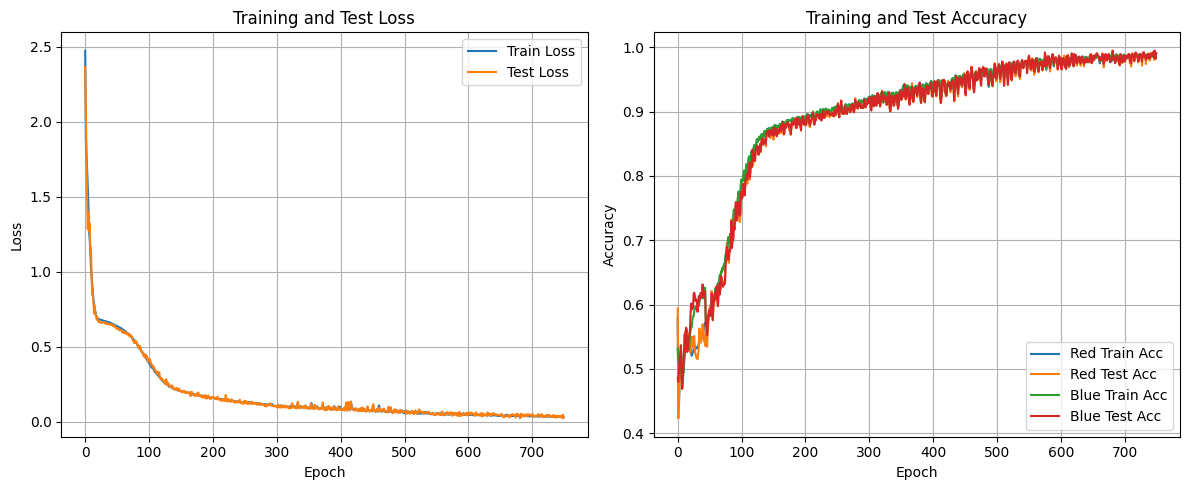

In [78]:
# Main execution flow
# 1. Augment training data by adding swapped versions
train_augmented = augment_training_data(train)
print(f"Original training data size: {len(train)}")
print(f"Augmented training data size: {len(train_augmented)}\n")

# 2. Create graph from augmented training data
G, edge_feature_cols = create_ufc_graph(train_augmented)

# 3. Convert to PyTorch Geometric data
data, node_idx, edge_dates = create_pytorch_geometric_data(G, edge_feature_cols)

# 4. Initialize and train symmetric model
model = SymmetricUFCNet(num_edge_features=len(edge_feature_cols), hidden_channels=128)
trained_model, training_metrics = train_model(model, data, edge_dates=edge_dates,
                                               test_percent=0.05, num_epochs=750)


# 5. Predict on validation set
validation_predictions = predict_validation(trained_model, data, node_idx, validation)
validation_swapped_symm = swap_red_blue_columns(validation)
validation_swapped_symm_prediction = predict_validation(trained_model, data, node_idx, validation_swapped_symm)

In [79]:
def average_predictions(original_predictions, swapped_predictions):
    """
    Average the predictions from original validation data and swapped validation data
    to create more symmetric final predictions.
    
    Args:
        original_predictions: DataFrame with predictions on original validation data
        swapped_predictions: DataFrame with predictions on swapped validation data
        
    Returns:
        DataFrame with averaged predictions
    """
    # Create a copy of the original predictions dataframe
    averaged_predictions = original_predictions[['red_fighter_name', 'blue_fighter_name']].copy()
    
    # Initialize columns for the averaged predictions
    averaged_predictions['red_win_prob'] = None
    averaged_predictions['blue_win_prob'] = None
    averaged_predictions['red_blue_diff'] = None
    averaged_predictions['blue_red_diff'] = None
    
    # Create a mapping for swapped predictions to make lookup easier
    # Key: (blue_fighter, red_fighter), Value: (red_win_prob, blue_win_prob)
    swapped_map = {}
    for _, row in swapped_predictions.iterrows():
        swapped_map[(row['red_fighter_name'], row['blue_fighter_name'])] = (
            row['red_win_prob'], row['blue_win_prob']
        )
    
    # For each row in the original predictions
    for idx, row in averaged_predictions.iterrows():
        red_fighter = row['red_fighter_name']
        blue_fighter = row['blue_fighter_name']
        
        # Get the original predictions, default to None if not available
        try:
            orig_red_win = original_predictions.loc[idx, 'red_win_prob']
            orig_blue_win = original_predictions.loc[idx, 'blue_win_prob']
        except:
            orig_red_win = None
            orig_blue_win = None
        
        # Look for the swapped matchup (blue fighter as red, red fighter as blue)
        if (blue_fighter, red_fighter) in swapped_map:
            # Get the swapped predictions
            swapped_red_win, swapped_blue_win = swapped_map[(blue_fighter, red_fighter)]
            
            # The swapped red_win is actually for the blue fighter in the original
            # and the swapped blue_win is for the red fighter in the original
            # So we need to swap them back
            swapped_red_win_corrected = swapped_blue_win  # Blue in swapped is red in original
            swapped_blue_win_corrected = swapped_red_win  # Red in swapped is blue in original
            
            # Average the predictions, handling None values
            if orig_red_win is not None and swapped_red_win_corrected is not None:
                avg_red_win = (float(orig_red_win) + float(swapped_red_win_corrected)) / 2
                averaged_predictions.at[idx, 'red_win_prob'] = avg_red_win
                averaged_predictions.at[idx, 'red_blue_diff'] = abs(float(orig_red_win) - float(swapped_red_win_corrected))
            elif orig_red_win is not None:
                averaged_predictions.at[idx, 'red_win_prob'] = float(orig_red_win)
            elif swapped_red_win_corrected is not None:
                averaged_predictions.at[idx, 'red_win_prob'] = float(swapped_red_win_corrected)
            
            if orig_blue_win is not None and swapped_blue_win_corrected is not None:
                avg_blue_win = (float(orig_blue_win) + float(swapped_blue_win_corrected)) / 2
                averaged_predictions.at[idx, 'blue_win_prob'] = avg_blue_win
                averaged_predictions.at[idx, 'blue_red_diff'] = abs(float(orig_blue_win) - float(swapped_blue_win_corrected))
            elif orig_blue_win is not None:
                averaged_predictions.at[idx, 'blue_win_prob'] = float(orig_blue_win)
            elif swapped_blue_win_corrected is not None:
                averaged_predictions.at[idx, 'blue_win_prob'] = float(swapped_blue_win_corrected)
        else:
            # If no matching swapped prediction, use original if available
            if orig_red_win is not None:
                averaged_predictions.at[idx, 'red_win_prob'] = float(orig_red_win)
            if orig_blue_win is not None:
                averaged_predictions.at[idx, 'blue_win_prob'] = float(orig_blue_win)
    
    return averaged_predictions

# Usage example:
averaged_results = average_predictions(validation_predictions, validation_swapped_symm_prediction)

In [80]:
averaged_results

,red_fighter_name,blue_fighter_name,red_win_prob,blue_win_prob,red_blue_diff,blue_red_diff
0,Marvin Vettori,Roman Dolidze,0.499727,0.500246,0.997702,0.997754
1,Chidi Njokuani,Elizeu Zaleski dos Santos,0.500531,0.499466,0.997068,0.99713
2,Alexander Hernandez,Kurt Holobaugh,0.500661,0.499319,0.996746,0.996735
3,Da'Mon Blackshear,Cody Gibson,0.507391,0.492748,0.984181,0.984459
4,Diyar Nurgozhay,Brendson Ribeiro,None,None,None,None
5,SeungWoo Choi,Kevin Vallejos,None,None,None,None
6,Waldo Cortes-Acosta,Ryan Spann,0.501004,0.498976,0.995382,0.995421
7,SuYoung You,AJ Cunningham,0.515568,0.48442,0.967888,0.967818
8,Carlos Vera,Josias Musasa,None,None,None,None
9,Stephanie Luciano,Sam Hughes,0.500593,0.499409,0.996717,0.996747


7 out of 9 correct on validation set

In [ ]:
validation_predictions

In [ ]:
validation_swapped_symm_prediction

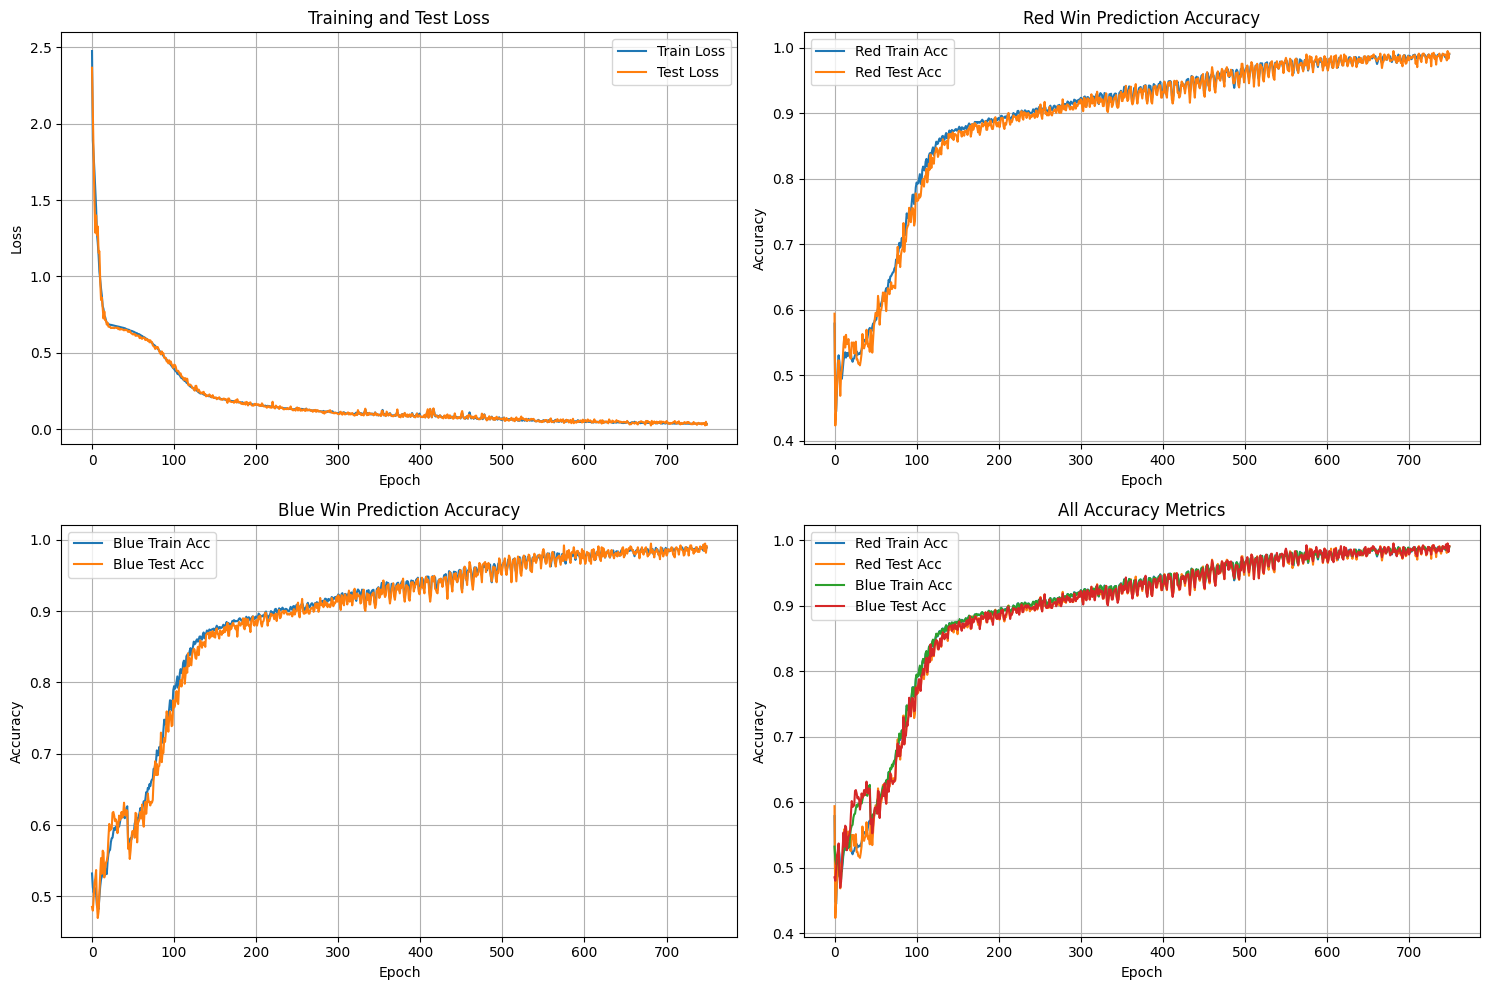

In [81]:
# You can also create more detailed plots if needed
plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(training_metrics['train_losses'], label='Train Loss')
plt.plot(training_metrics['test_losses'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

# Red accuracy plot
plt.subplot(2, 2, 2)
plt.plot(training_metrics['red_train_accs'], label='Red Train Acc')
plt.plot(training_metrics['red_test_accs'], label='Red Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Red Win Prediction Accuracy')
plt.legend()
plt.grid(True)

# Blue accuracy plot
plt.subplot(2, 2, 3)
plt.plot(training_metrics['blue_train_accs'], label='Blue Train Acc')
plt.plot(training_metrics['blue_test_accs'], label='Blue Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Blue Win Prediction Accuracy')
plt.legend()
plt.grid(True)

# Combined accuracy plot
plt.subplot(2, 2, 4)
plt.plot(training_metrics['red_train_accs'], label='Red Train Acc')
plt.plot(training_metrics['red_test_accs'], label='Red Test Acc')
plt.plot(training_metrics['blue_train_accs'], label='Blue Train Acc')
plt.plot(training_metrics['blue_test_accs'], label='Blue Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('All Accuracy Metrics')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()